In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
import os
import torch
from scipy.stats import norm

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from IProbNorm.utils import normal_interval_probability, normal_bin_pmf

from IProbNorm import (
    IVT_MC,
    IVT_JL,
)

In [3]:
def predict_plot(model, X, Y=None):
    with torch.no_grad():
        probs_t = model.predict(X, approximate=True)
        str_raw = ""
        plt.figure(figsize=(6, 6))

        mu = probs_t[0]
        sigma = probs_t[1]

        trim_percentage = 0.05

        prob = normal_interval_probability(interval_bounds=Y, sigma=sigma, mu=mu, trim_percentile=trim_percentage)

        def average_adjacent_difference(sequence):
            if len(sequence) < 2:
                return 0

            differences = []
            for i in range(len(sequence) - 1):
                diff = sequence[i + 1] - sequence[i]  # правый - левый
                differences.append(diff)

            return sum(differences) / len(differences), differences

        probs_t = model.predict(X, approximate=False)
        probs = probs_t.squeeze().detach().numpy()

        avg_width, differences = average_adjacent_difference(model.interval_bounds)
        differences = [1] + differences + [1]

        probs = probs / np.asarray(differences)

        plt.step(model.interval_bounds, probs[:-1], where='post', label='Class probabilities', alpha=0.6)

        bounds = torch.arange(
            start=model.interval_bounds[0],
            end=model.interval_bounds[-1] + 1e-10,
            step=avg_width,
            dtype=torch.float32,
            device=model.device
        )

        probs_norm = normal_bin_pmf(interval_bounds=bounds, sigma=sigma, mu=mu)
        probs = probs_norm[:, 0] if probs_norm.ndim == 2 else probs_norm

        x = bounds.cpu().numpy()
        y = probs.cpu().numpy()

        lower_q = norm.ppf(trim_percentage, loc=mu, scale=sigma)  # ≈ μ - 1.645σ
        upper_q = norm.ppf(1 - trim_percentage, loc=mu, scale=sigma)  # ≈ μ + 1.645σ

        plt.axvline(x=lower_q, color='grey', linestyle='-', label='Estimated interval')
        plt.axvline(x=upper_q, color='grey', linestyle='-')

        x_norm = x
        y_norm = y

        y_norm /= avg_width

        plt.step(x_norm, y_norm, label=f'Approximated normal',
                 linestyle='-', alpha=1, color='k', where='post')
        
        plt.xlabel('Y')
        plt.ylabel('p(Y|X)')
        plt.grid(True)

        plt.axvline(x=Y[0], color='r', linestyle='--', alpha=0.5, label='Interval bounds')
        plt.axvline(x=Y[1], color='r', linestyle='--', alpha=0.5)

        plt.legend()
        plt.show()

def plot_fit_results(model, examples_count=5, approximate=True):
    plot_data = [
        (model.losses_train, model.losses_val, 'Loss'),
        (model.log_losses_train, model.log_losses_val, 'LogLoss'),
        (model.brier_train, model.brier_val, 'Brier'),
    ]

    best_results = {'best_epoch': model.best_epoch}
    if not model.best_epoch_pi is None:
        best_results['best_epoch_pi'] = model.best_epoch_pi

    for p_d in plot_data:
        plot_label = p_d[2]

        best_results[plot_label] = p_d[1][model.best_epoch]
        if not model.best_epoch_pi is None:
            best_results[plot_label + '_pi'] = p_d[1][model.best_epoch_pi]

        plt.figure(figsize=(10, 6))
        plt.plot(p_d[0], label=f'Train {plot_label}', linestyle='--')
        plt.plot(p_d[1], label=f'Val {plot_label}', linestyle='-')

        plt.xlabel('Epoch')
        plt.ylabel(f'{plot_label}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    for i in range(np.min(np.array([model.X_val.shape[0], examples_count]))):
        X_new = model.X_val[i]
        X_new = X_new[np.newaxis, :]
        Y_new = model.Y_val[i]
        predict_plot(model=model, X=X_new, Y=Y_new)

In [4]:
def display_dataset(X, Y):
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[50, 1])
    N_points = X.shape[0]

    ax2 = fig.add_subplot(gs[0, 0])
    indices = np.arange(N_points) + 1
    yl = Y[:, 0]
    yh = Y[:, 1]

    ax2.vlines(indices, yl, yh, color='gray', lw=3)
    ax2.plot(indices, yl, 'o', color='red', label='yl')
    ax2.plot(indices, yh, 'o', color='blue', label='yh')

    for i in range(N_points):
        ax2.hlines(yl[i], xmin=0, xmax=indices[i], linestyle='--', color='gray', linewidth=0.8, alpha=0.8)
        ax2.hlines(yh[i], xmin=0, xmax=indices[i], linestyle='--', color='gray', linewidth=0.8, alpha=0.8)
        ax2.plot(0, yl[i], marker='x', color='red', markersize=6, alpha=0.8)
        ax2.plot(0, yh[i], marker='x', color='blue', markersize=6, alpha=0.8)

    ax2.set_xlim(left=0, right=N_points + 0.5)
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Intervals [yl, yh]')
    ax2.set_title('Intervals Y')
    ax2.legend()
    ax2.grid(True)

    plt.show()


# Example (Linear dependence)

In [5]:
def generate_dataset_normal(N, dim, par, sigma, sigma2, width):
    par = np.asarray(par)

    X = np.random.uniform(0, 1, (N, dim))
    noise = np.random.normal(0, sigma, N)
    y = X.dot(par) + noise

    interval_width = np.abs(np.random.normal(width, sigma2, N))

    yl = y - interval_width/2.0
    yh = y + interval_width/2.0

    Y_interval = np.column_stack((yl, yh))

    display_dataset(X, Y_interval)
    
    return X, Y_interval

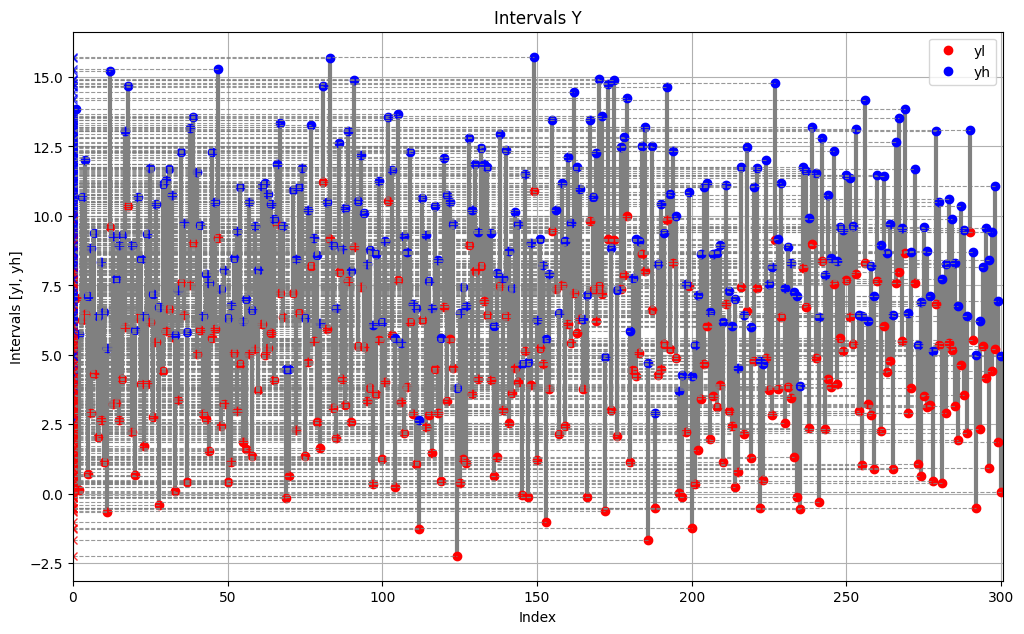

In [6]:
rnd_seed = 42

np.random.seed(rnd_seed)
X, y = generate_dataset_normal(N=300, dim=3, par=np.array([2.0, 4.0, 8.0]), sigma=0.1, sigma2=1.0, width=5.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## IVT_MC model

Epoch 0: train=0.7935401022434234 train_br=0.28700941503047944 val=0.8506069779396057 val_br=0.31178752581278485 
Epoch 1: train=0.7465218096971512 train_br=0.2618660792708397 val=0.7955329020818075 val_br=0.2826712131500244 
Epoch 2: train=0.6629946291446686 train_br=0.22332578748464585 val=0.7558192014694214 val_br=0.262063667178154 
Epoch 3: train=0.6261618137359619 train_br=0.20590980723500252 val=0.7461340030034384 val_br=0.2521480768918991 
Epoch 4: train=0.6107637345790863 train_br=0.1980414628982544 val=0.7449813485145569 val_br=0.25114358961582184 
Epoch 5: train=0.6103397697210312 train_br=0.19453588202595712 val=0.7576653957366943 val_br=0.2527509232362111 
Epoch 6: train=0.614734098315239 train_br=0.19727520272135735 val=0.7397768497467041 val_br=0.24918883542219797 
Epoch 7: train=0.6086521953344345 train_br=0.19574033170938493 val=0.7377493977546692 val_br=0.24954150120417276 
Epoch 8: train=0.610734099149704 train_br=0.1984536275267601 val=0.7399911681811014 val_br=0.247

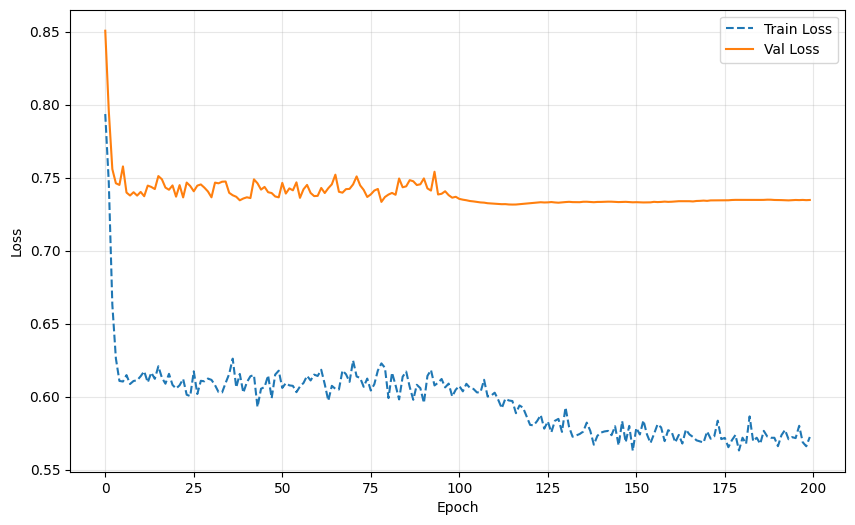

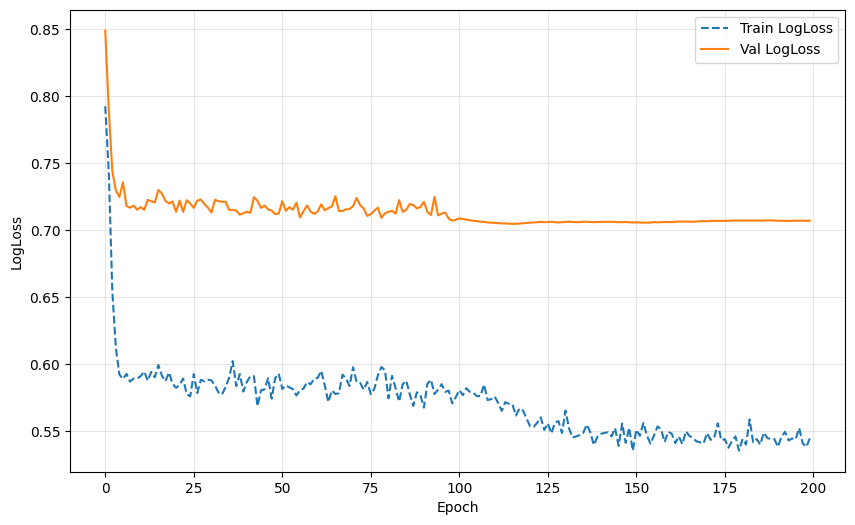

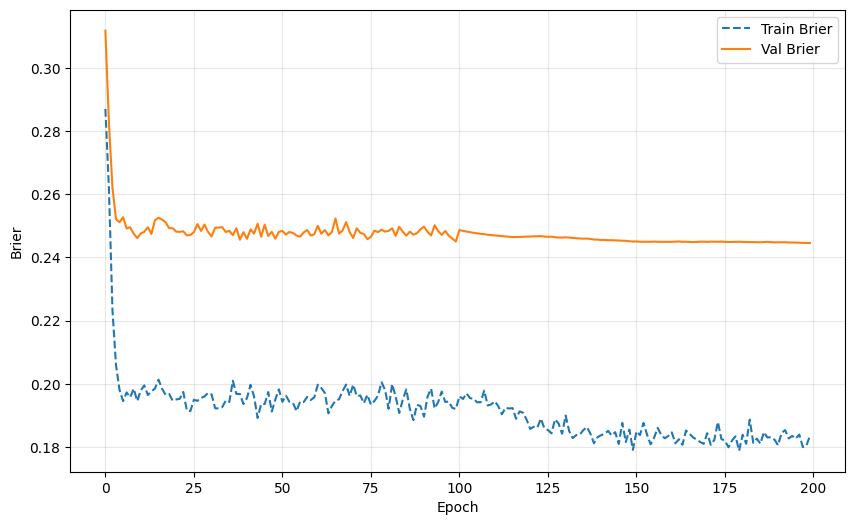

C:\Users\ad\Documents\GitHub\Diplomka\IProbNorm\utils.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interval_bounds = torch.tensor(interval_bounds, dtype=torch.float32)


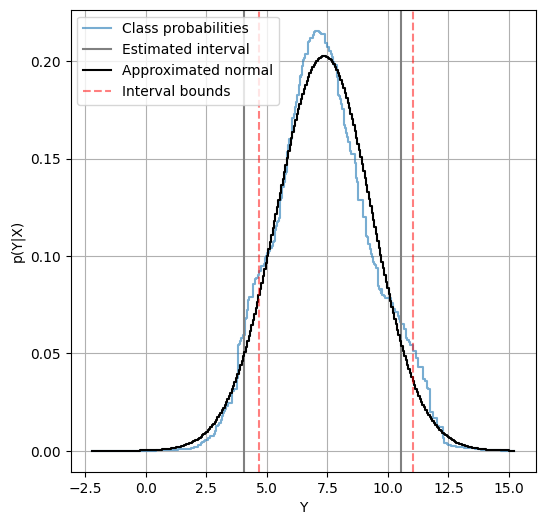

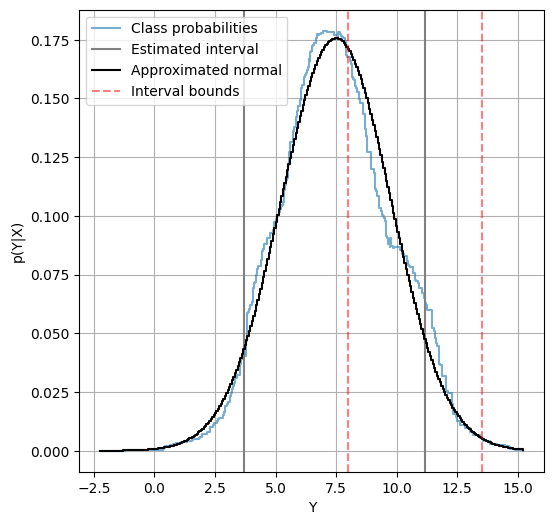

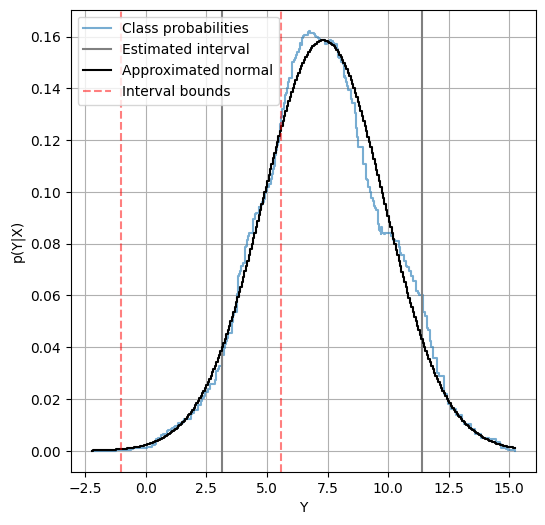

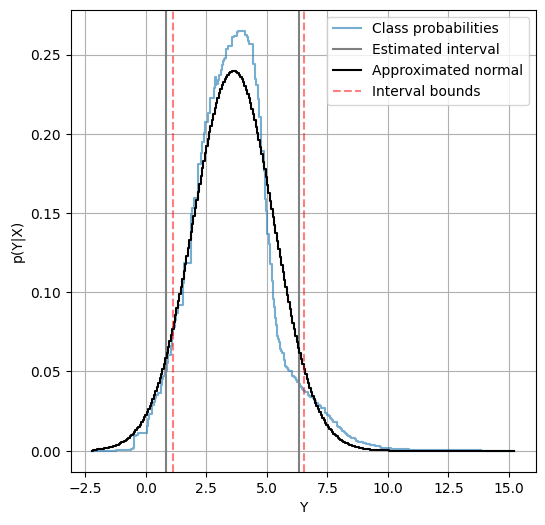

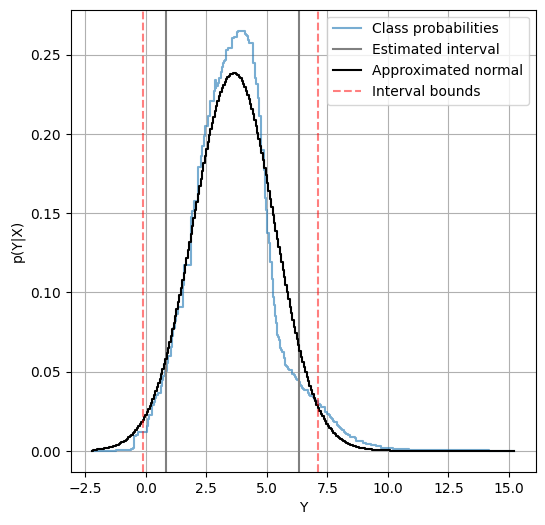

In [7]:
model_MC = IVT_MC(debug=True)
model_MC.fit(X_train, y_train, X_test, y_test, epochs=100, epochs_pi=100)
plot_fit_results(model=model_MC)

## IVT_MC model with gauss kernel

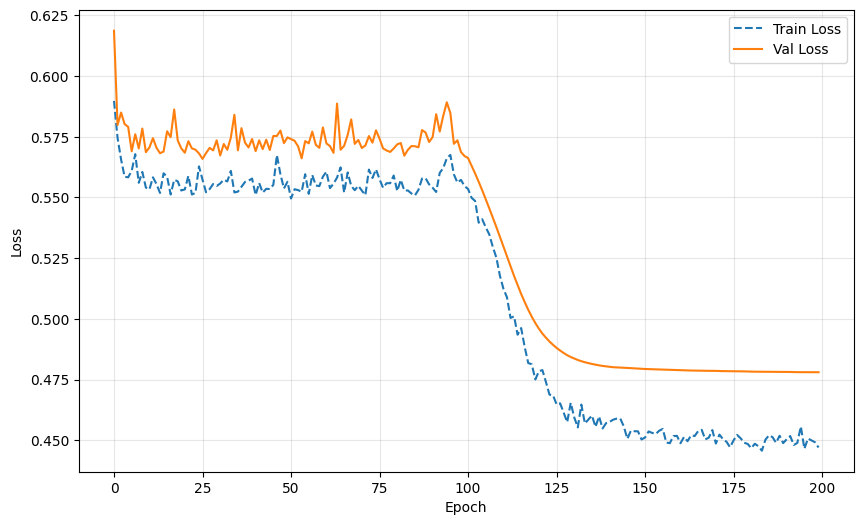

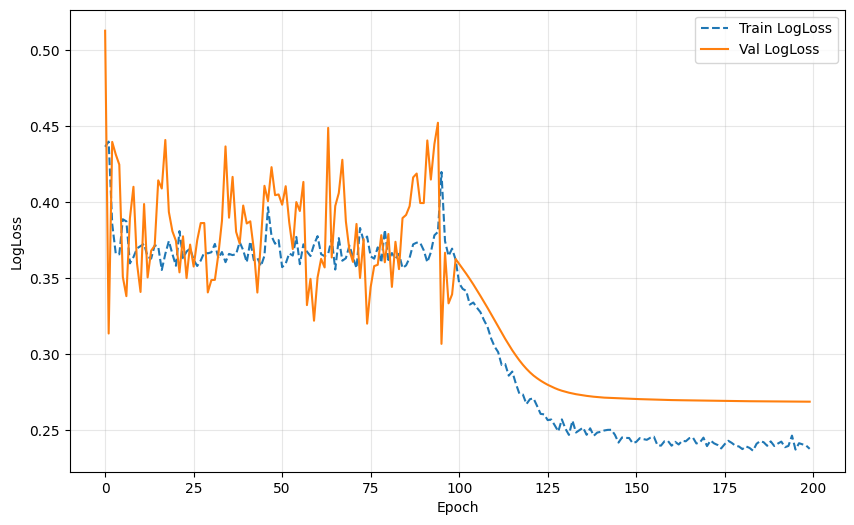

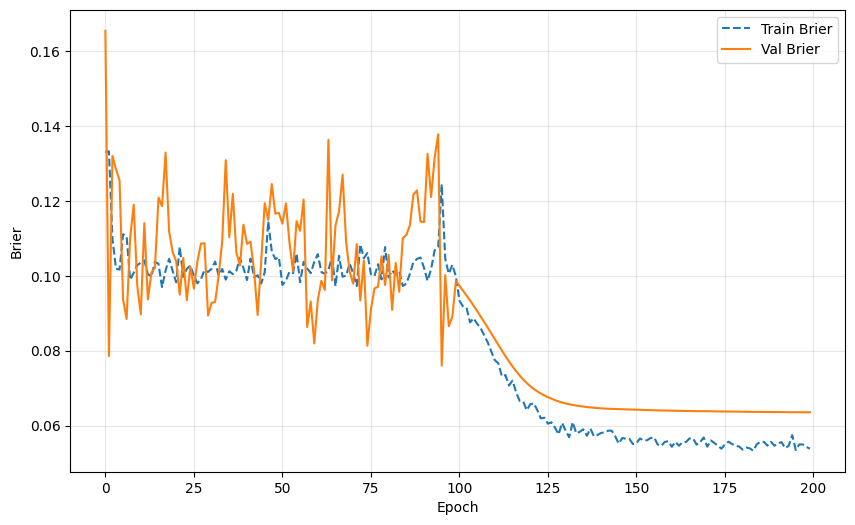

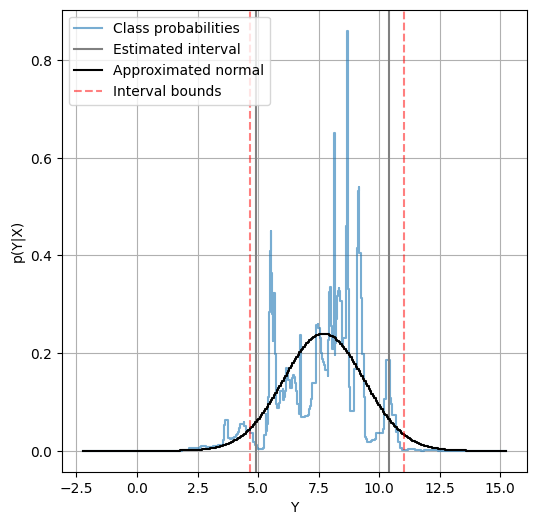

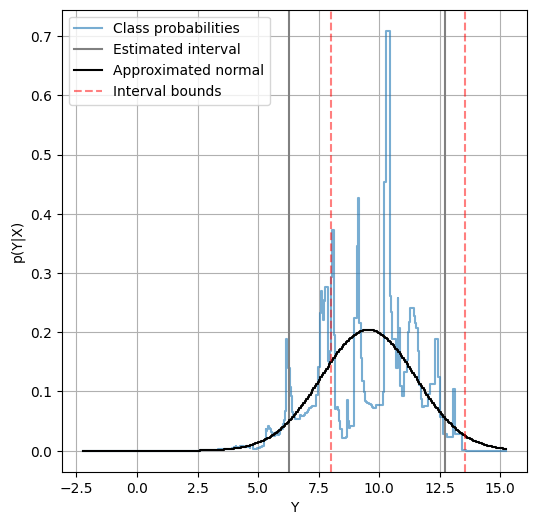

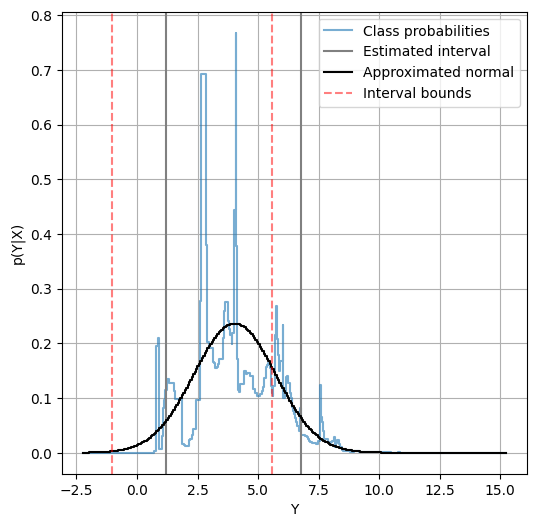

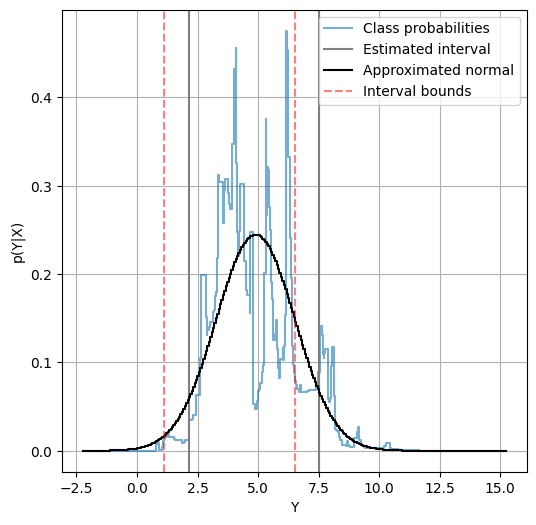

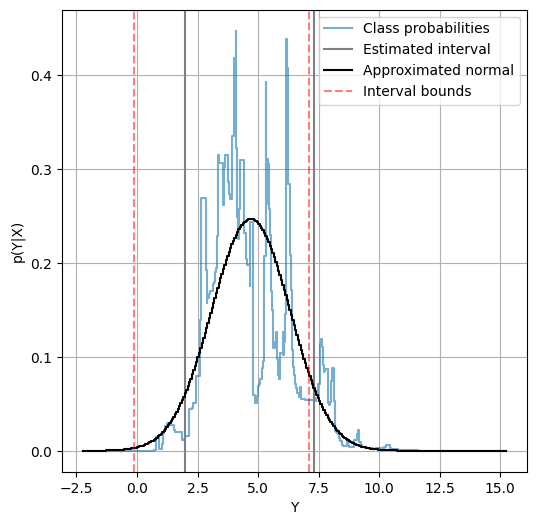

In [8]:
model_MC = IVT_MC(tau=0.5, tau_learnable=True, gauss_kernel=True)
model_MC.fit(X_train, y_train, X_test, y_test, epochs=100, epochs_pi=100)
plot_fit_results(model=model_MC)

## IVT_JL model

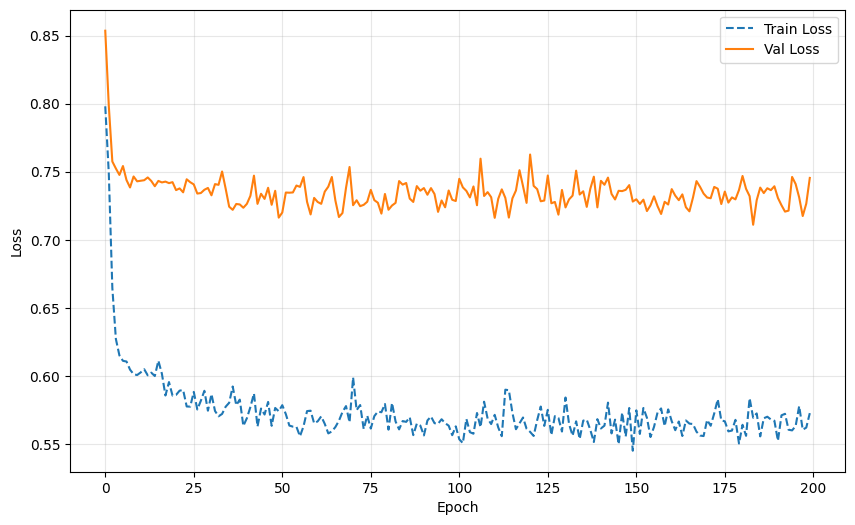

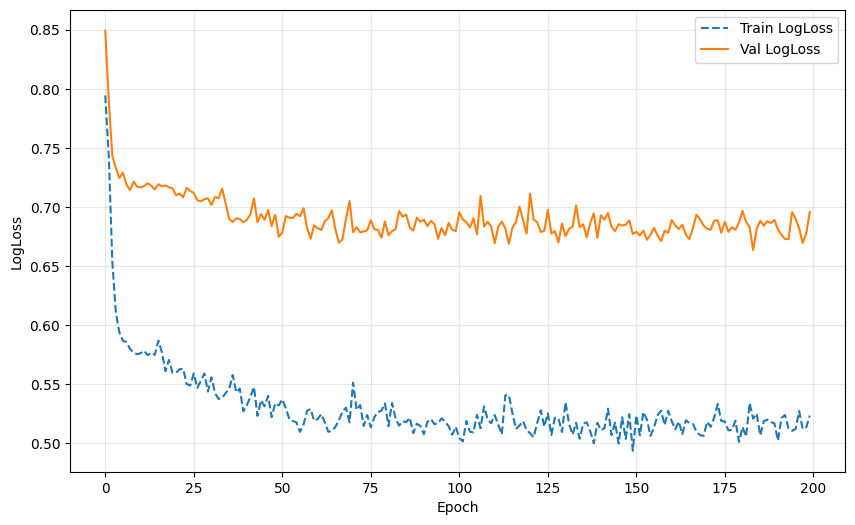

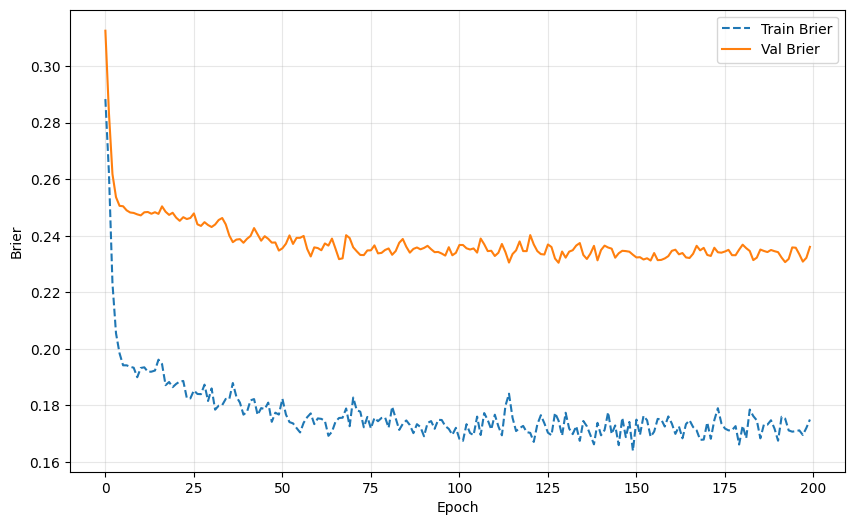

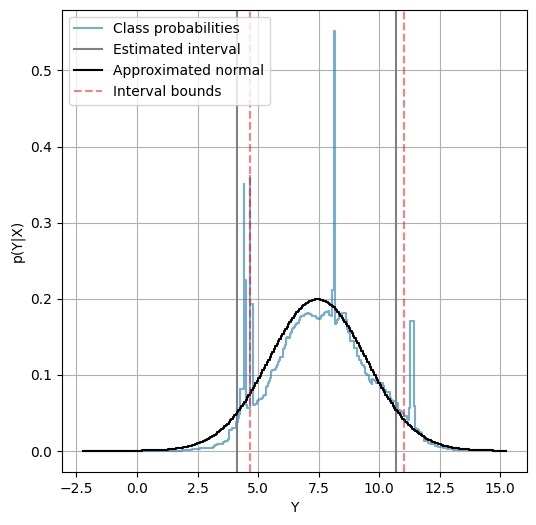

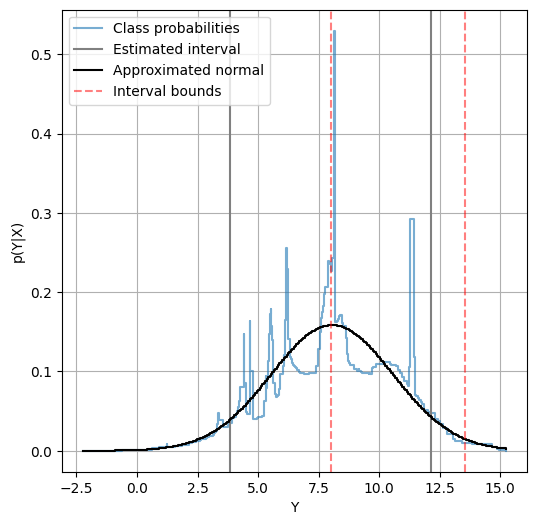

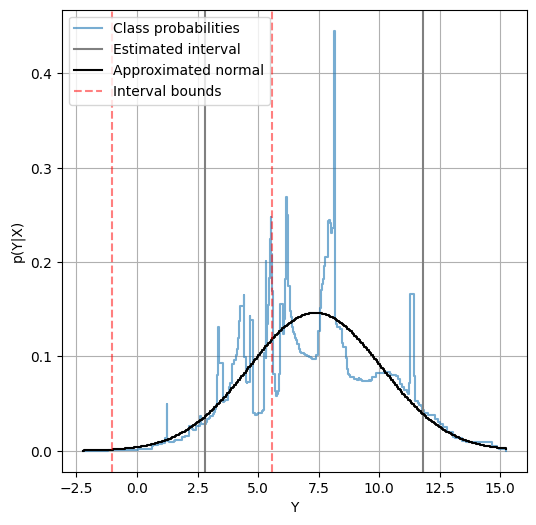

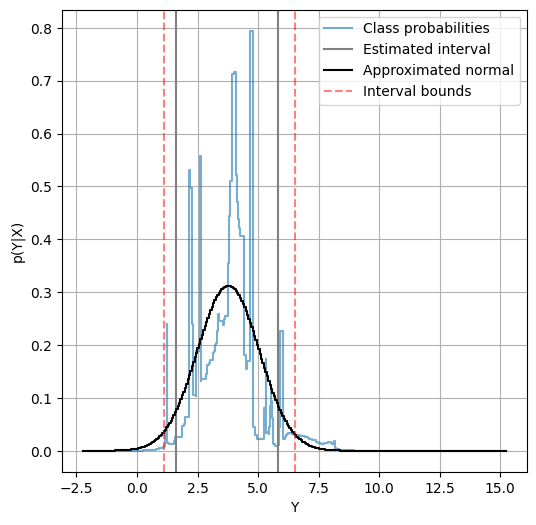

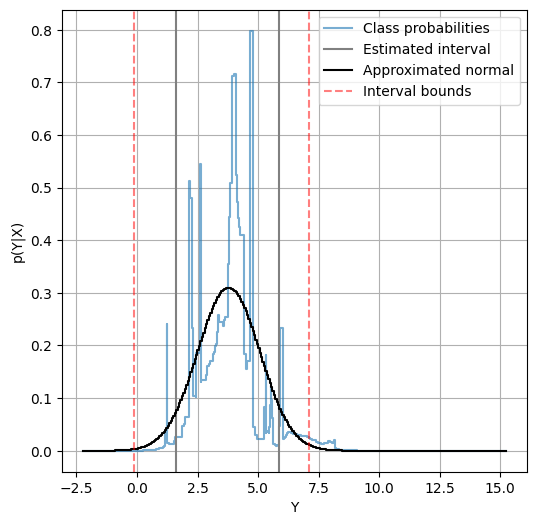

In [9]:
model_JL = IVT_JL()
model_JL.fit(X_train, y_train, X_test, y_test, epochs=200)
plot_fit_results(model=model_JL)

## IVT_JL model with gauss kernel

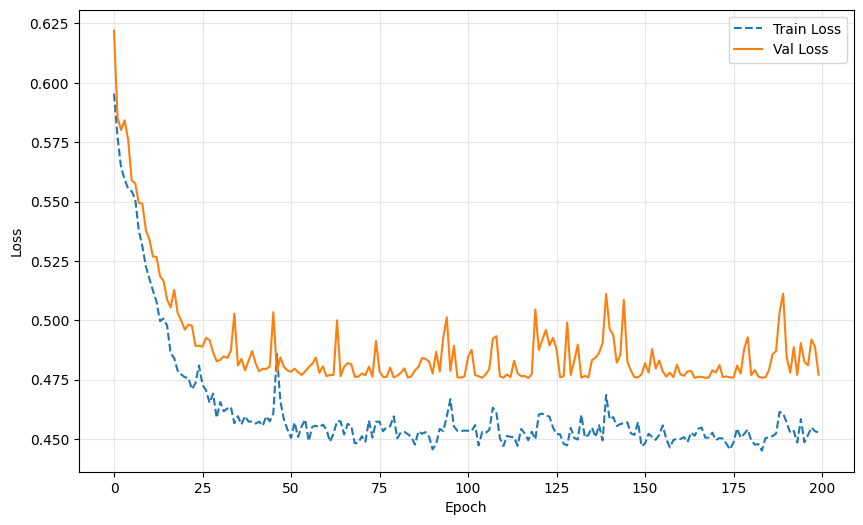

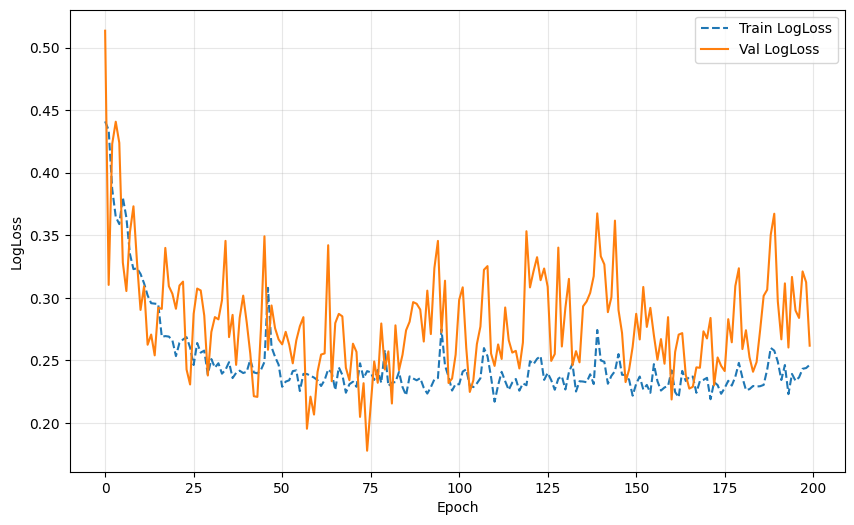

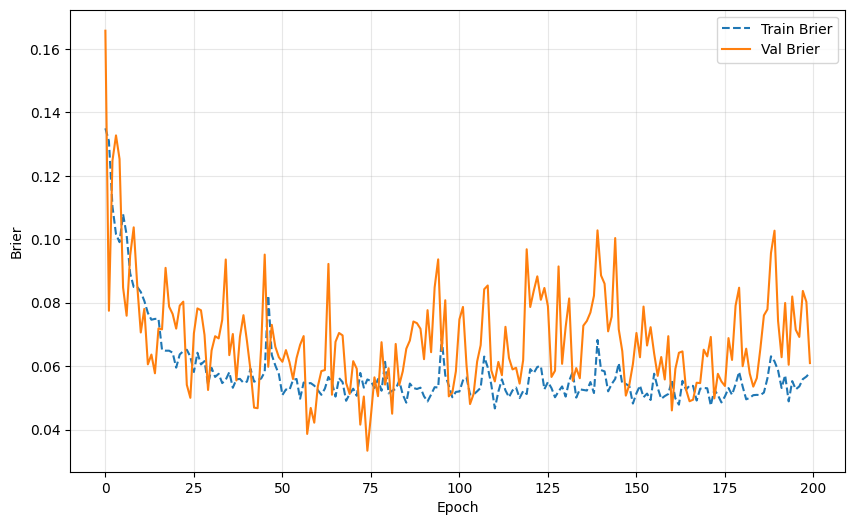

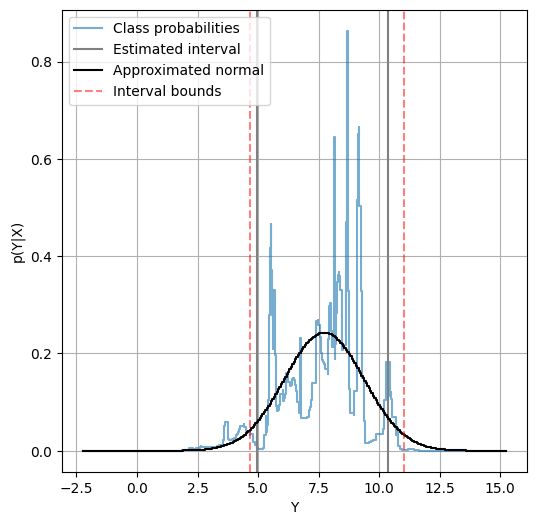

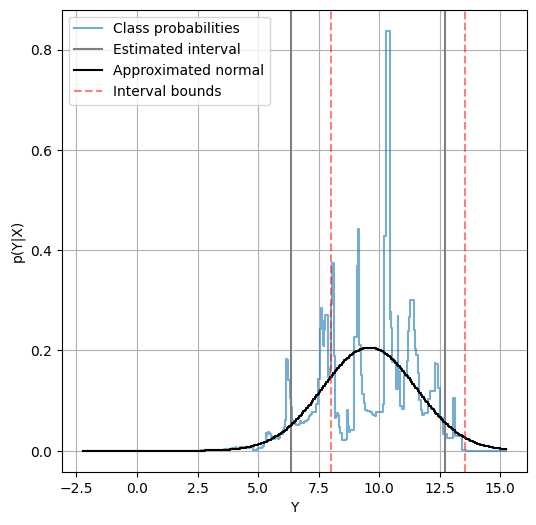

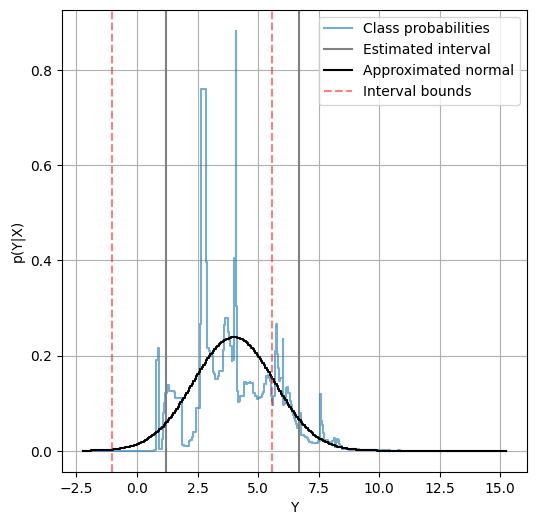

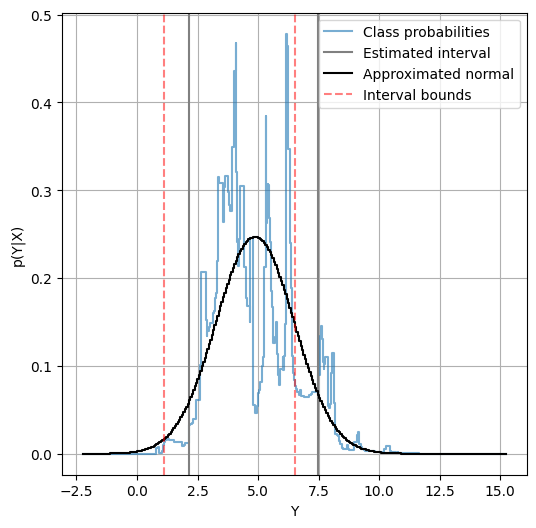

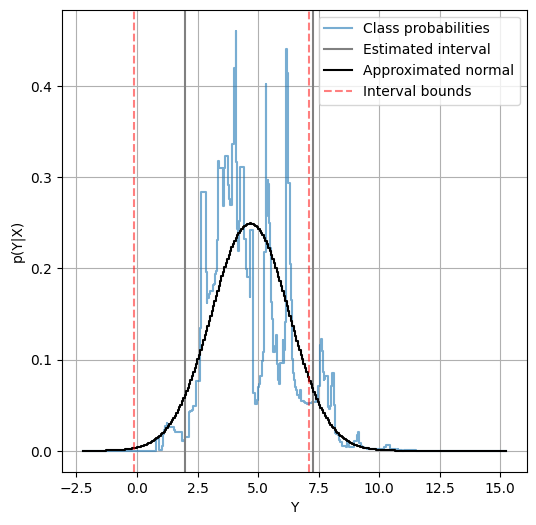

In [10]:
model_JL = IVT_JL(tau=0.5, tau_learnable=True, gauss_kernel=True)
model_JL.fit(X_train, y_train, X_test, y_test, epochs=200)
plot_fit_results(model=model_JL)

# Example (Archimedean Spiral)

In [11]:
def generate_dataset_spiral(N, dim, sigma2, width):
    T = np.random.uniform(0.0, 10.0, N)
    X = np.zeros((N, dim))

    for i in range(0, dim, 2):
        freq = 1 + i // 2
        X[:, i] = T * np.sin(T * freq)
        if i + 1 < dim:
            X[:, i + 1] = T * np.cos(T * freq)

    A = np.random.uniform(0.6, 1, N)
    B = np.random.uniform(0.6, 1, N)

    y = A * T + B

    interval_width = np.abs(np.random.normal(width, sigma2, N))

    yl = y - interval_width/2.0
    yh = y + interval_width/2.0

    Y_interval = np.column_stack((yl, yh))
    return X, Y_interval

In [12]:
rnd_seed = 42

np.random.seed(rnd_seed)
X, y = generate_dataset_spiral(N=300, dim=5, sigma2=1.0, width=6.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## IVT_MC model

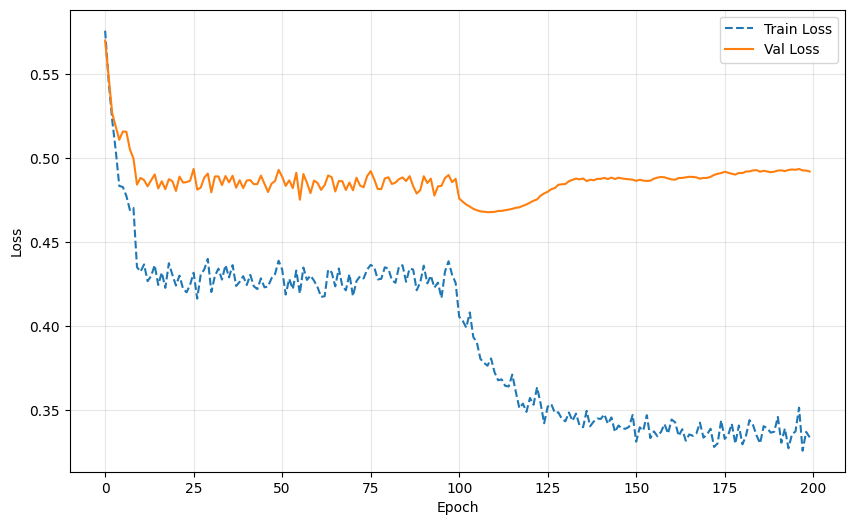

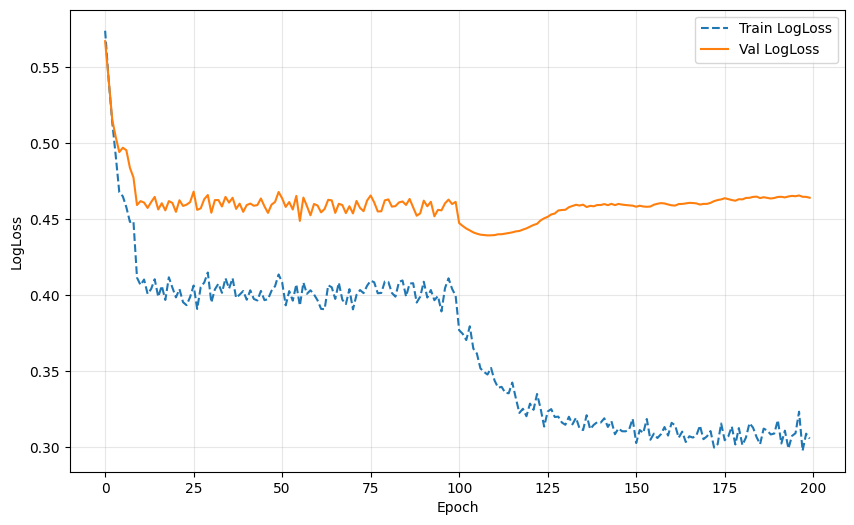

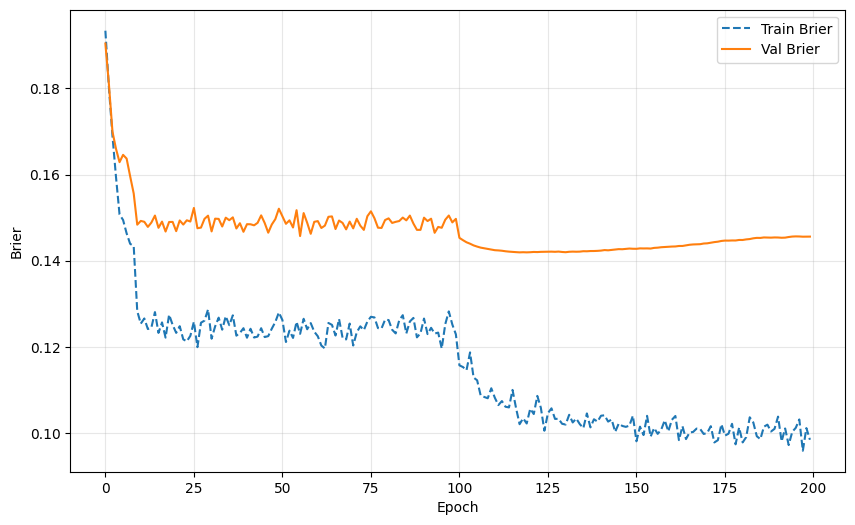

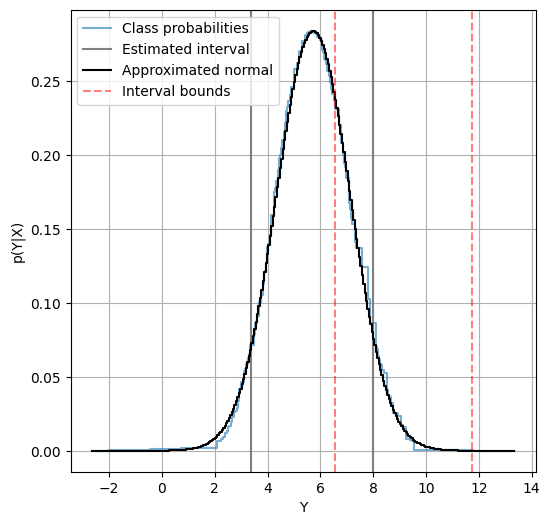

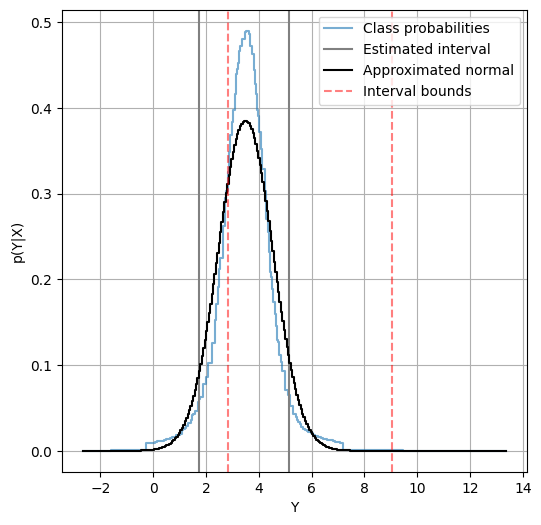

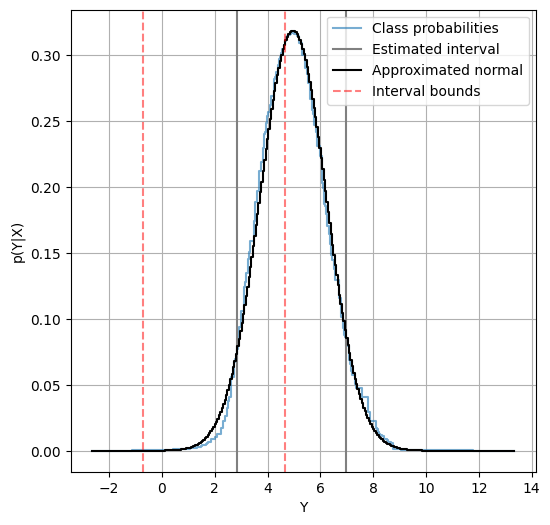

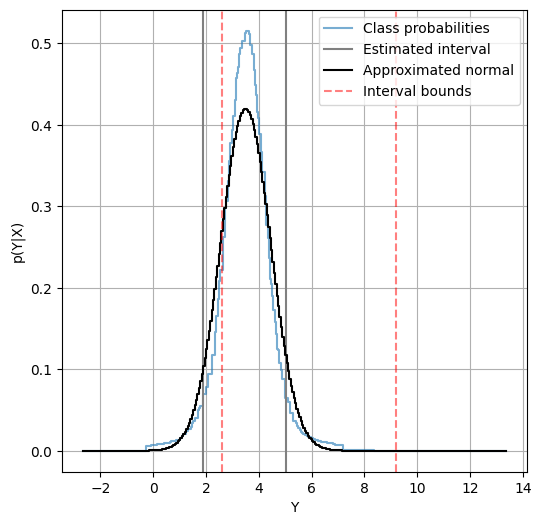

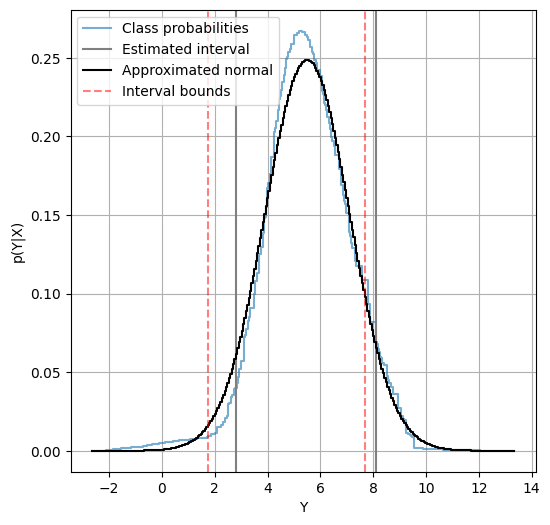

In [13]:
model_MC = IVT_MC()
model_MC.fit(X_train, y_train, X_test, y_test, epochs=100, epochs_pi=100)
plot_fit_results(model=model_MC)

## IVT_JL model

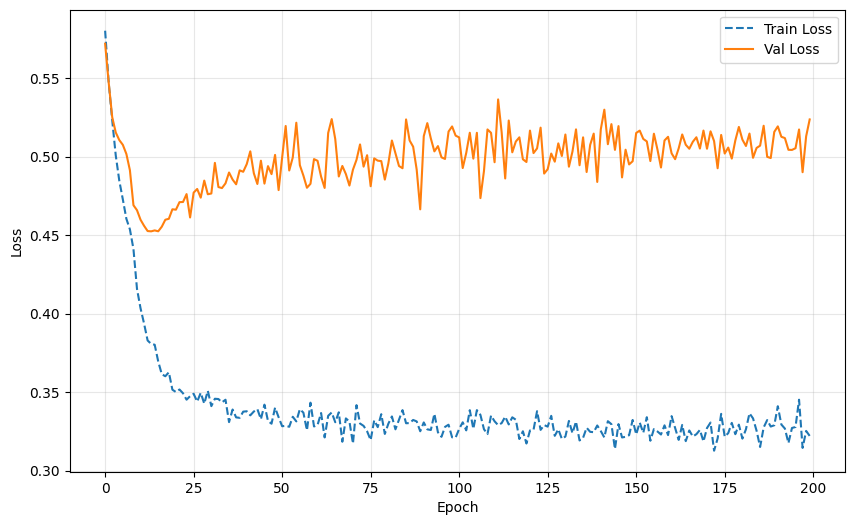

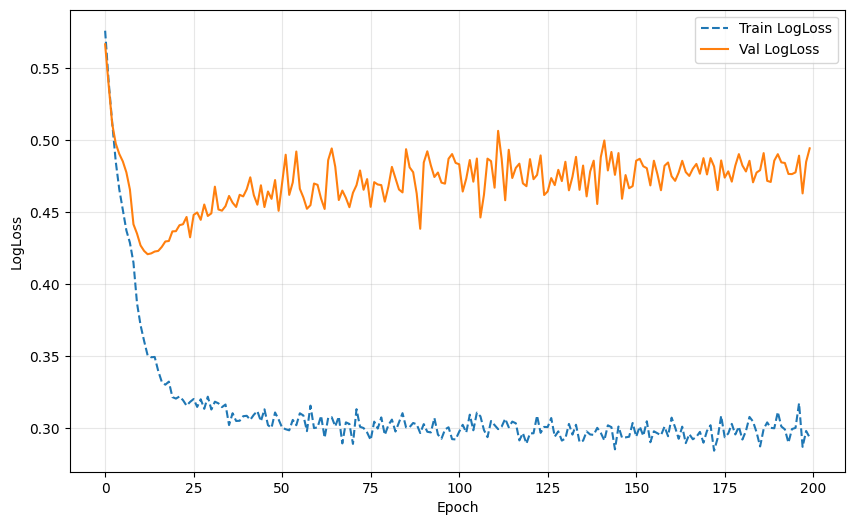

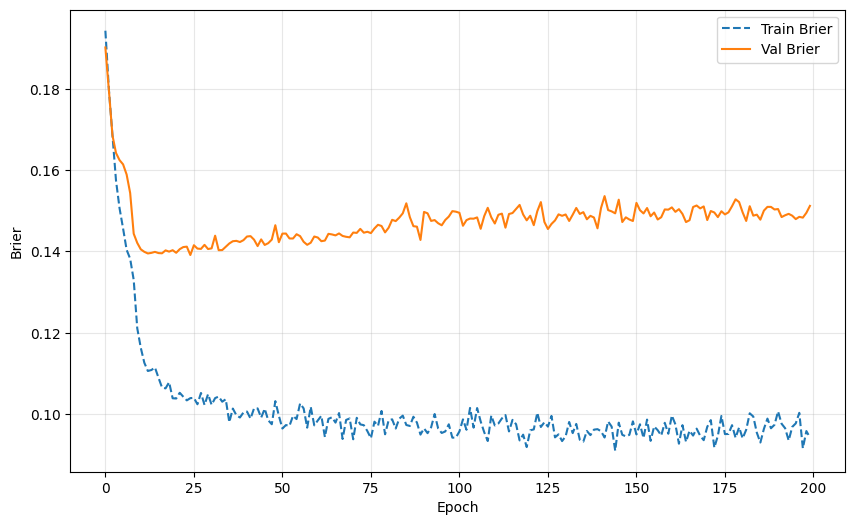

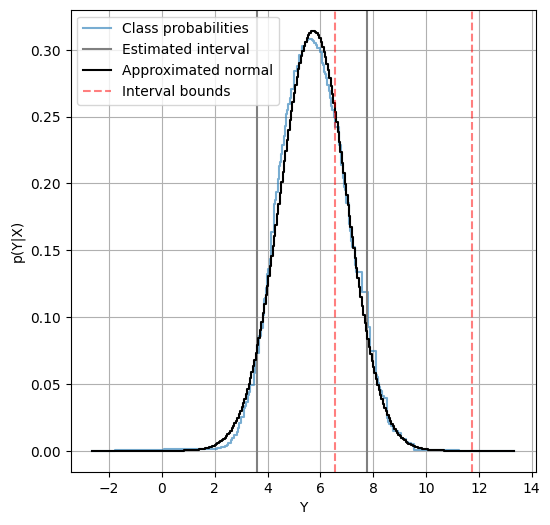

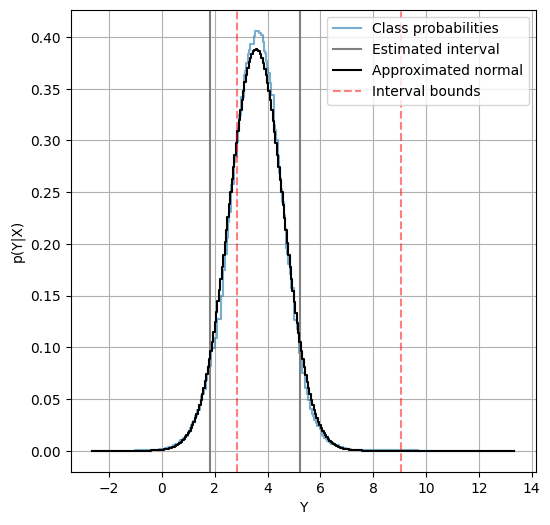

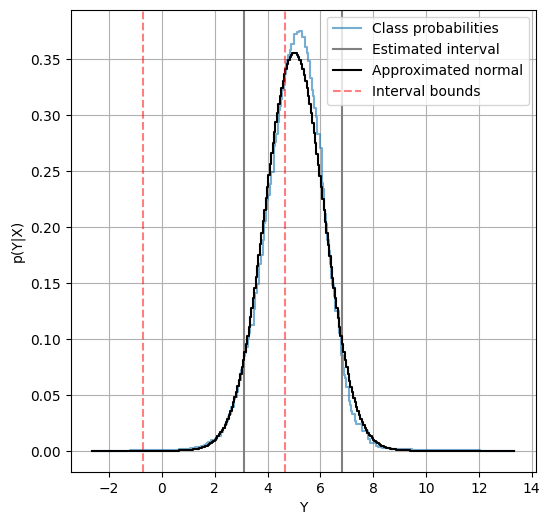

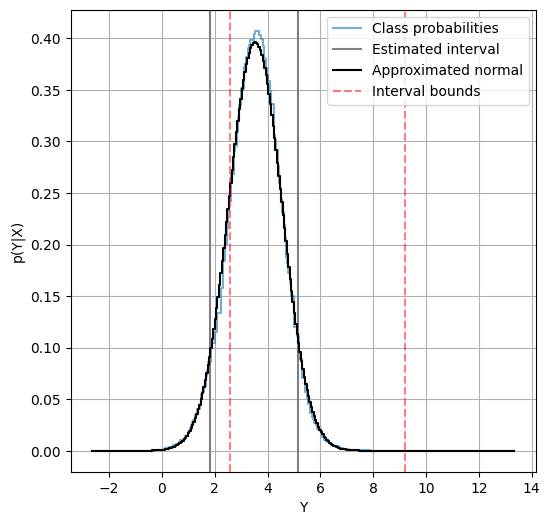

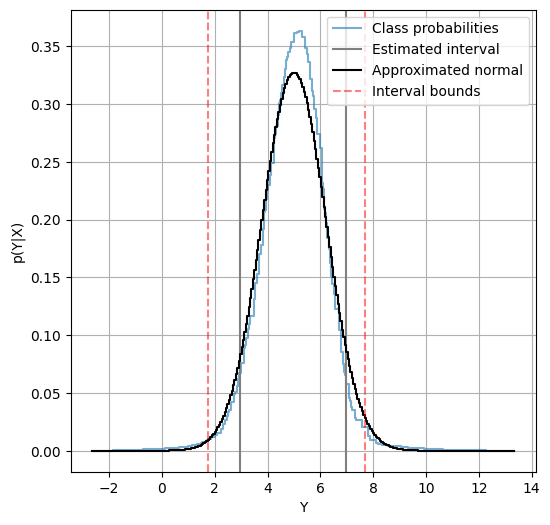

In [14]:
model_JL = IVT_JL()
model_JL.fit(X_train, y_train, X_test, y_test, epochs=200)
plot_fit_results(model=model_JL)